In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import numpy as np



from utils import MonomerMasses
from plotting import plotTwoMassSpectra, plotMassSpectrum, plot_spots
from massCluster import findLargestMassPeak

from new_utils import read_desi_data_file, get_average_intensity_of_scan, get_spots, combine_scans, mass_to_monomer
from new_utils import identify_masses_from_sequencing, find_parent_mass

import matplotlib.pyplot as plt


Setting threshold to 34780.74380267702 counts
[INFO] Found 6 extrema in the spot scan. This means there are six peaks/samples.
Extreme point 3 has scans [1, 2, 3, 4]
Extreme point 12 has scans [9, 10, 11, 12, 13, 14, 15]
Extreme point 22 has scans [20, 21, 22, 23, 24]
Extreme point 32 has scans [29, 30, 31, 32, 33, 34, 35, 36]
Extreme point 43 has scans [40, 41, 42, 43, 44, 45]
Extreme point 53 has scans [50, 51, 52, 53, 54, 55, 56]


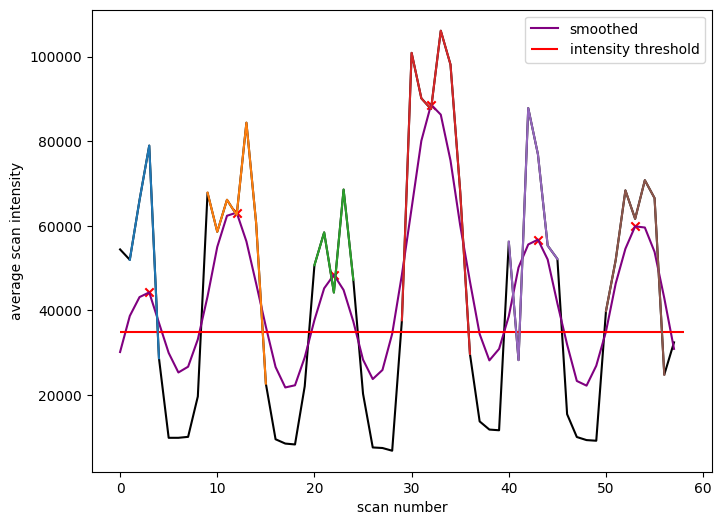

In [2]:
endcap_mass = 262.084
endcap_name = 'Tyr(OMe)'

# this is the scan intensity that you check to see what is noise and what is oligos
intensity_threshold = 'auto'

# Set the maximum spot width
spot_width = 6

# Debug
debug = True

# Rounding for something in the reading/cleaning up of scans
mz_round = 3

# Define the monomer masses
MonomerMasses = {
    101.0477:'Ala',
    103.0602:'D2Ala',
    115.0633:'Abu',
    117.0759:'D2Abu',
    127.0633:'Gly(allyl)',
    129.0759:'D2Allyl',
    131.0582:'Ser',
    133.0708:'D2Ser',
    143.0946:'Leu',
    145.1072:'D2Leu',
    177.0790:'Phe',
    179.0915:'D2Phe',
    183.1259:'Cha',
    185.1385:'D2Cha',
    191.0949:'HoPhe',
    193.0739:'Tyr(OH)',
    193.1072:'D2HoPhe',
    195.0864:'D2Tyr(OH)',
    207.0895:'TyrOMe',
    209.1021:'D2TyrOMe',
}

file = Path('./julia_data/04172024_oligomers_CVprofiling_A-F_3rdtry.txt')
#file = Path('./julia_data/04172024_oligomers_CVprofiling_A-F_1sttry.txt')

# Get a list of scans in the file
scans = read_desi_data_file(file, mz_round=mz_round)

# Get the average intensities
average_scan_intensities = [get_average_intensity_of_scan(x, mass_thresh=500) for x in scans]

# Get the spots from the spectrum
spots = get_spots(intensities=average_scan_intensities, 
                  threshold=intensity_threshold, 
                  spot_width=spot_width, 
                  look_ahead_bias=1,
                  polyorder=2,
                  plot_smoothed=True,
                  debug=debug)

In [3]:

# Combine all of the scans that are associated with a peak in the
combined_scans = [combine_scans([scans[i] for i in spot_group]) for spot_group in spots]

0
1
2
[WARNING] Small parent peaks can cause unusual results with thresholds larger than 0.01.
[ 439.163  511.293  544.486  570.221  665.346  747.3    842.424  856.44
  864.375  865.378 1033.52  1034.524 1048.509 1049.515 1050.518 1051.518
 1052.52  1239.604 1240.611 1241.613 1242.615 1243.616 1417.688 1418.691
 1419.693 1240.61   865.379 1051.519 1417.689 1418.692  511.294  864.376
 1033.521 1241.614]
[DEBUG] spot_idx: 2	Parent mass in spectrum: 1417.689	Intensity: 4731742.0
[DEBUG] intensity_percent: 0.2	first intensity_threshold: 4704001.600000001	LargestMassPeakIntensity: 4731742.0 counts.
[DEBUG] In endcap range 225.878858 - 340.136254
[DEBUG] Upperbound mass 163.057254 was lower than the minimum mass 262.084
[DEBUG] Selected masses: [1417.689, 1240.61, 1049.515, 864.375, 747.3, 570.221, 439.163, 262.084]
	MONOMER: 1417.689 - Phe
	MONOMER: 1240.61 - HoPhe
	MONOMER: 1049.515 - D2Cha
	MONOMER: 864.375 - D2Abu
	MONOMER: 747.3 - Phe
	MONOMER: 570.221 - Ser
	MONOMER: 439.163 - Phe
	END

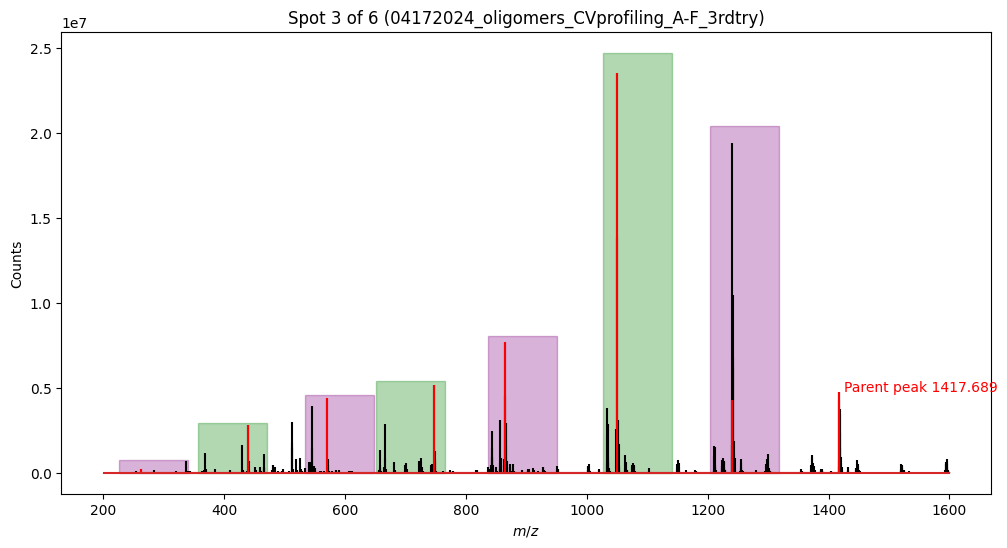

3
4
5


In [4]:
dataframes_for_spots = []
ms_spectra_for_spots = []
name = 'tmp'

intensity_threshold = 0.20
parent_peak_threshold = 0.01

monomer_tolerance = 1

# Iterate over every spot (which is the combined intensities over all scans which were done for that spot)
for spot_idx, scan in enumerate(combined_scans):

    # Initiate plotting here so we can plot within other functions
    fig, ax = plt.subplots(1,1, figsize = (12,6))

    ScansTemp = pd.DataFrame(list(scan.items()), columns=['Mass', 'Intensity'])

    # Find the parent oligomer mass
    parent_mass = find_parent_mass(scanData=ScansTemp, 
                                   threshold = parent_peak_threshold, 
                                   debug=debug)
    parent_mass_intensity = float(ScansTemp[ScansTemp["Mass"] == parent_mass]['Intensity'].iloc[0])

    #if i == 1:
    #    exit('DEBUG EXITING')
    if debug:
        print(f'[DEBUG] spot_idx: {spot_idx}\tParent mass in spectrum: {parent_mass}\tIntensity: {parent_mass_intensity}')

    # Find the peaks
    FoundSpectraMassesIntensity, window_bounds = identify_masses_from_sequencing(scan_data=ScansTemp, 
                                                                                 mass_monomer_definitions=MonomerMasses,
                                                                                 parent_mass=parent_mass,
                                                                                 intensity_threshold=intensity_threshold,
                                                                                 endcap_mass=endcap_mass, 
                                                                                 debug=debug)

    # Convert the mass:intensity pairs into list of masses
    FoundSpectraMasses = list(FoundSpectraMassesIntensity.keys())
    
    # Get the deltas for these
    deltas = []
    for i, m in enumerate(FoundSpectraMasses):
        if i == len(FoundSpectraMasses) - 1:
            break
        deltas.append(float(m) - FoundSpectraMasses[i + 1])
    
    # Add endcap (last mass found) to the deltas list
    deltas.append(FoundSpectraMasses[-1])
    

    MassMatches = [mass_to_monomer(x, 
                                   mass_monomer_definitions=MonomerMasses, 
                                   monomer_tolerance=monomer_tolerance, 
                                   endcap_mass=endcap_mass, 
                                   endcap_name=endcap_name, 
                                   debug=debug) for x in deltas]

    # This is just stored for printing
    results = []

    # Iterate over the masses
    for j, mass_found_in_spectrum in enumerate(FoundSpectraMasses):
        if j == len(MassMatches):
            print(f'[WARNING] There were {j} or more masses identified in spectrum while we have {len(MassMatches)} mass matches')
            break
        if MassMatches[j] == endcap_name:
            print(f'\tENDCAP : {mass_found_in_spectrum} (target={endcap_mass}) - {MassMatches[j]}')
            results.append([j, endcap_mass, endcap_name + '(endcap)'])
        else:
            results.append([j, mass_found_in_spectrum, MassMatches[j]])
            print(f'\tMONOMER: {mass_found_in_spectrum} - {MassMatches[j]}')

    result = pd.DataFrame(results, columns=['Signal No.', 'M/Z', 'Monomer lost']).set_index('Signal No.')

    # Append the result dataframe
    dataframes_for_spots.append(result)

    for i, bound_tuple in enumerate(window_bounds):
        if i % 2 == 0:
            color = 'purple'
        else:
            color = 'green'
        h = ScansTemp[(ScansTemp['Mass'] >= bound_tuple[0]) & (ScansTemp['Mass'] <= bound_tuple[1])].Intensity.max() * 1.05
        rect = plt.Rectangle((bound_tuple[0], 0), width = bound_tuple[1] - bound_tuple[0], height = h, color=color, alpha = 0.3)
        plt.gca().add_patch(rect)

    # Plot the full spectrum
    x, y = zip(*sorted(scan.items()))
    ax.stem(x, y, linefmt='black', markerfmt='')
    ax.set_title(f"Spot {spot_idx + 1} of {len(spots)} ({file.stem})")
    ax.set_ylabel('Counts')
    ax.set_xlabel(r'$m/z$')
    ax.stem(FoundSpectraMassesIntensity.keys(), FoundSpectraMassesIntensity.values(), linefmt='red', markerfmt='') #, width=1.5

    ax.text(parent_mass*1.005, parent_mass_intensity * 1.005, f'Parent peak {parent_mass}', color='red')

    tmp_image_path = Path(file.parent / str(name + f'_spot_{spot_idx + 1}' + ".png"))
    #plt.savefig(tmp_image_path, format='png', dpi = 600)
    plt.show()
    ms_spectra_for_spots.append(tmp_image_path)


